In [1]:
import qiskit as qk
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.options.sampler_options import SamplerOptions
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from pprint import pprint
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# See also https://docs.quantum.ibm.com/guides/primitives-examples 
! pip3 list |grep qiskit

PennyLane-qiskit                  0.36.0
qiskit                            1.1.0
qiskit-aer                        0.14.2
qiskit-algorithms                 0.3.0
qiskit-ibm-experiment             0.4.7
qiskit-ibm-runtime                0.23.0
qiskit-ionq                       0.5.1
qiskit-machine-learning           0.7.2

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [14]:
service = QiskitRuntimeService(channel="ibm_quantum")

In [12]:
backends = service.backends()
print(backends)
for i,backend in enumerate(backends): print(backend)


[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_cusco')>, <IBMBackend('ibm_nazca')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]
<IBMBackend('ibm_brisbane')>
<IBMBackend('ibm_cusco')>
<IBMBackend('ibm_nazca')>
<IBMBackend('ibm_torino')>
<IBMBackend('ibm_osaka')>
<IBMBackend('ibm_kyoto')>
<IBMBackend('ibm_kyiv')>
<IBMBackend('ibm_sherbrooke')>


In [15]:
#service = QiskitRuntimeService(name="olcf")
#service = QiskitRuntimeService(channel="ibm_quantum")
options = SamplerOptions()
options.default_shots=1000

In [18]:
#...!...!....................
def create_ghz_circuit(n):
    qc = qk.QuantumCircuit(n)
    qc.h(0)
    for i in range(1, n):  qc.cx(0, i)
    qc.measure_all()
    return qc
qc=create_ghz_circuit(5)
print(qc)

        ┌───┐                     ░ ┌─┐            
   q_0: ┤ H ├──■────■────■────■───░─┤M├────────────
        └───┘┌─┴─┐  │    │    │   ░ └╥┘┌─┐         
   q_1: ─────┤ X ├──┼────┼────┼───░──╫─┤M├─────────
             └───┘┌─┴─┐  │    │   ░  ║ └╥┘┌─┐      
   q_2: ──────────┤ X ├──┼────┼───░──╫──╫─┤M├──────
                  └───┘┌─┴─┐  │   ░  ║  ║ └╥┘┌─┐   
   q_3: ───────────────┤ X ├──┼───░──╫──╫──╫─┤M├───
                       └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                            └───┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4 


### A) Run on real HW



In [16]:
# [<IBMBackend('ibm_cusco')>, <IBMBackend('ibm_nazca')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_osaka')>,
# <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_brisbane')>]
#backName='ibm_kyoto'
backName='ibm_kyiv'
#backName='ibm_quebec'
backend = service.get_backend(backName)

Here we create a pass manager based on the backend and then we run the pass manager on the virtual circuit to create the physical circuit ready to run

In [17]:
# transpiler(..) is now generate_preset_pass_manager(..)
mypass = generate_preset_pass_manager(backend=backend,optimization_level=3, seed_transpiler=44)
qcT = mypass.run(qc)

NameError: name 'qc' is not defined

In [ ]:
qcT.draw('mpl', idle_wires=False)

In [ ]:
#qcT.draw('text', idle_wires=False)

In [ ]:
qcEL=(qcT,)  # quant circ executable list
sampler = Sampler(backend=backend, options=options)
job = sampler.run(qcEL)
result=job.result()

In [ ]:
pprint(result[0].data.meas.get_counts())

### B) Run on fake backend

In [4]:
backName='ibm_torino'
#backName='ibm_kyoto'
noisy_backend = service.get_backend(backName)
backend2 = AerSimulator.from_backend(noisy_backend)

qcT = qk.transpile(qc, backend=backend2, optimization_level=3)
print('use noisy_backend =', noisy_backend.name )

use noisy_backend = ibm_torino


transpiled CX-depth: 7


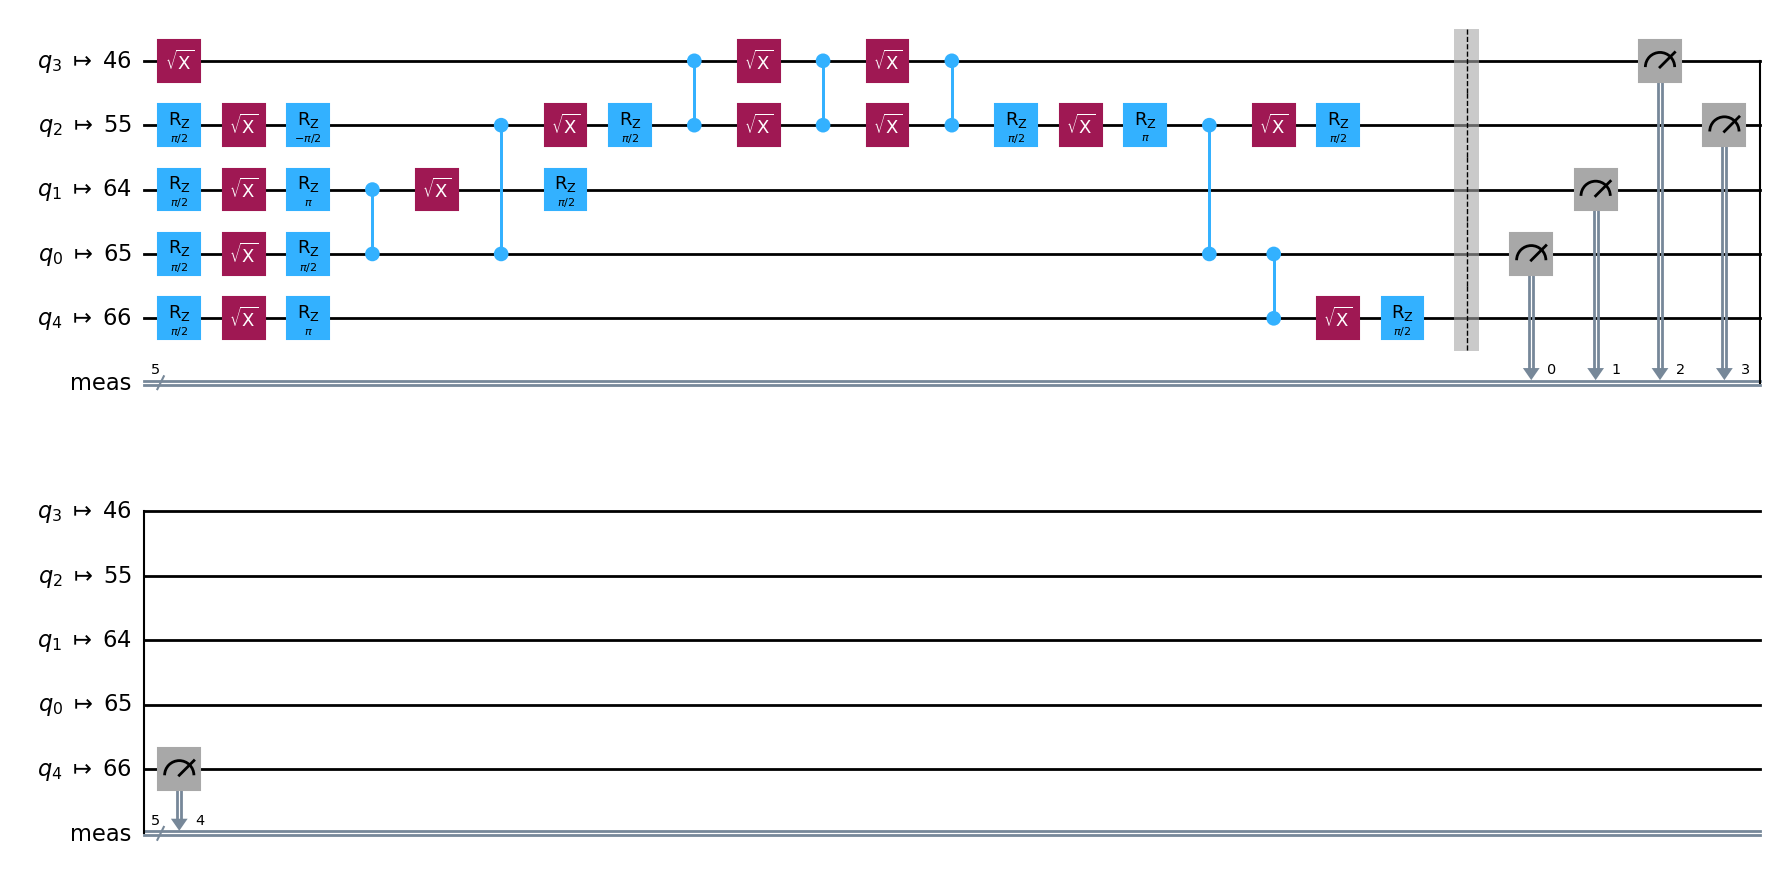

In [5]:
print('transpiled CX-depth:',qcT.depth(filter_function=lambda x: x.operation.num_qubits == 2 ))
#print(qcT.draw(output='text',idle_wires=False)) 
qcT.draw('mpl', idle_wires=False)

In [6]:
print('job started,  nq=%d  at %s ...'%(qcT.num_qubits,backend2.name))
sampler = Sampler(backend=backend2, options=options)
job = sampler.run([qcT])
result=job.result()
jobMD=result.metadata    

job started,  nq=133  at aer_simulator_from(ibm_torino) ...


In [7]:
pprint(result[0].data.meas.get_counts())

{'00000': 471,
 '00001': 4,
 '00010': 11,
 '00100': 16,
 '01000': 4,
 '01011': 1,
 '01111': 4,
 '10000': 4,
 '10100': 1,
 '10111': 11,
 '11001': 3,
 '11011': 18,
 '11101': 11,
 '11110': 4,
 '11111': 437}


C) Run on ideal backend

In [ ]:
backend3 = AerSimulator()
print('job started,  nq=%d  at %s ...'%(qcT.num_qubits,backend3.name))
sampler = Sampler(backend=backend3, options=options)
qcT = qk.transpile(qc, backend=backend3, optimization_level=3)
job = sampler.run([qcT])
result=job.result()
pprint(result[0].data.meas.get_counts())

In [ ]:
print(qc)